
# Code for Master's Thesis: Topic Modeling

## Research Questions

1. Welche Themen können mithilfe von Topic Modeling aus den DHd-Abstracts
der Tagungen zwischen 2014 und 2023 gefunden werden?

*Which topics can be found in the abstracts from DHd-conferences between 2014 and 2023 with Topic Modeling?*

2. Welche Themen kommen häufig gemeinsam in einem Dokument vor und weisen
daher eine hohe Themenähnlichkeit (topic similarity) auf?

*Which topics appear frequently in one abstract and therefore have a high topic similarity?* **Hierarchical Clustering**

3. Wie haben sich die Themenschwerpunkte im Verlauf der Jahre verändert -
welche Trends sind zu erkennen?

*How have the topics been changing throughout the years - which trends are perceptible?* **Mann-Kendall-Test**

4. Welche Entwicklungen sind in Bezug auf die Verwendung verschiedener Forschungsmethoden festzustellen?

*Which developments with regard to the use of different scientific methods are perceptible?*

5. Welche Personen sind besonders häufig mit Abstracts vertreten, in welchen
Autor:innenteams treten sie auf und wie verändern sich diese im Zeitverlauf?

*Which researchers contribute to the conference particularly frequently with abstracts, in which teams do they contribute and how have the teams been changing?*

6. Welche Personencluster sind in Bezug auf die Themenschwerpunkte zu erkennen und wie verändern sich diese?

*Which clusters of researchers can be found with regard to topics and how have the clusters been changing?* **Network Analysis**

### Imports

In [95]:
#Reading in necessary pdf- and xml-files
import zipfile
from bs4 import BeautifulSoup
'''Vermerken: PyPDF2 hat die Zeichen nicht gut erkannt und daher sind einige Wörter herausgefallen'''
import PyPDF2
import fitz
from io import BytesIO

#(pre)processing the files
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
from langdetect import detect
from gensim.models import TfidfModel
import pickle

#LDA
import gensim
import gensim.corpora as corpora
import os

#Evaluation
from gensim.models import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt

#Visualisations
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import scipy.cluster.hierarchy as shc

#Hellinger Distance
from gensim.matutils import hellinger
from scipy.spatial.distance import squareform

#Mann-Kendall-Test
import pymannkendall as mk



### Preprocessing function: eliminating non-German texts from corpus

In [96]:
def detect_language(text):
    
    #gets text as input
    lang = detect(text)

    #returns the language tag of detected language
    return lang        

### Preprocessing function: cleaning the texts

In [97]:
def clean_text(text):
        
    # filtering paragraphs from text
    clean = re.sub(r'\n', "", str(text))

    # filtering abbreviations, weblinks, digits and markup from XML      
    abbreviations = ['bspw.', 'sog.', 'vgl.', 'u.a.', 'z.B.', 'bzw.', r'http(.*?) ', r'\d', r'<(.*?)>', 'e.g.', 'also']
    for word in abbreviations:
        clean = re.sub(word, '', clean)

    # filtering punctuation
    punctuation = '''!“()´`¨[]{}\\;:”",<>/.?@#$%^&*_~''' 
    for word in clean:
        if word in punctuation:
            clean = clean.replace(word, "")

    # returns cleaned-up texts
    return clean

### Preprocessing function: removing stopwords and very short/long words

In [98]:
def remove_stopwords(text, language):
    
    # import German stopword list 
    stops_de = set(stopwords.words('german'))
    stops_en = set(stopwords.words('english'))
    
    # convert a document into a list of lowercase tokens, ignoring tokens that are too short (min_len=2) or too long (max_len=15), no deaccentation (by default)
    words = gensim.utils.simple_preprocess(text)
    
    # filter stopwords
    words_filtered = []
    for w in words:
        if language == 'de' and w not in stops_de:
            words_filtered.append(w)
        elif language == 'en' and w not in stops_en:
            words_filtered.append(w)
    
    # return list of words that are NOT stopwords
    return words_filtered


### Preprocessing function: (morpho-syntactic) lemmatization
- Lemmatizing the words in the texts to their dictionary form according to the detected language
- Hint: 'de_core_news_md' and 'en_core_web_sm' models have to be downloaded via pip beforehand

In [99]:
def lemmatization(texts, language):
    
    # only words tagged as nouns, verbs, adjectives and adverbs should be considered
    allowed_tags = ['NOUN', 'VERB', 'ADJ', 'ADV']

    # disabling parser and ner-tool to accelerate computing 
    nlp_de = spacy.load('de_core_news_md', disable=['parser', 'ner'])
    nlp_en = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    texts_out = []
    for text in texts:
        if language == 'de':
            doc = nlp_de(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_tags:
                    new_text.append(token.lemma_.lower())
        elif language == 'en':
            doc = nlp_en(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_tags:
                    new_text.append(token.lemma_.lower())
            
        # delete all empty sets where the pos-tag was not in allowed list
        if new_text != []:        
            final = " ".join(new_text)
            texts_out.append(final)
    
    # return list of lemmatized words
    return (texts_out)

### Function: Extracting Keywords from XML-File
- extracts tags \<keywords n="topics" scheme="ConfTool"> and \<keywords n="keywords" scheme="ConfTool"> to get keywords of the texts
- checks validity of keywords

In [100]:
def extract_keywords(xmldata):
    
    # finds all tags <keywords n="keywords"> and <keywords n="topics">, removes all tags within
    keywords = str(soup.find_all("keywords", {"n": ("keywords", "topics")}))
    keywords = re.sub("<(.*?)>", "", keywords)
    keywords = keywords.split("\n")

    # filters keywords shorter than 2 letters
    for item in keywords:
        if len(item) <= 2 and item in keywords:
            keywords.remove(item)
            
    # returns list
    return keywords

### Function: Counting number of extracted keywords
- function creates dictionary from the list of keywords
- counts how often each method is used
- returns the dictionary

In [101]:
def count_methods(keywords_year):
    
    methods_dict = {}
    # for each item in keyword list, check if it is alredy in dictionary
    # if not, add and set count to 1, if yes add +1 to count
    for item in keywords_year:
        if item not in methods_dict.keys():
            methods_dict[item] = 1
        else:
            methods_dict[item] += 1
    # sort dictionary according to highest count in the values
    sorted_dict = sorted(methods_dict.items(), key=lambda x: x[1], reverse=True)

    # return the sorted dictionary
    return sorted_dict

### Function: Extracting the author names
Extracts the names of the authors and returns a list of lists containing the names of the single texts' authors

In [102]:
def extract_authors(title_stmt):
    # returns a list of authors for each of the texts
    ''' Evtl so anpassen, dass je Jahr/Zip nochmal eine eigene Liste erstellt wird? '''
    ''' WIE GENAU SOLL DIE NETZWERKANALYSE LAUFEN? '''
    
    all_authors = []
    # navigating to the title statement and finding all tags <author>
    authors = title_stmt.find_all("author")
    fore_and_surnames = []
    
    # extracting the <surname> and <forename> tags and cleaning the outcome from the tags and the brackets
    for element in authors:
        names = element.find_all(['surname', 'forename'])
        names =  re.sub("<(.*?)>", "", str(names))
        names = re.sub("</(.*?)>", "", str(names))
        names = re.sub(r'\]', "", names)
        names = re.sub(r'\[', "", names)
        fore_and_surnames.append(names)
    # all_authors.append(fore_and_surnames)
    
    return fore_and_surnames

### Function: Extracting text from XML-files

In [103]:
def extract_xml_text(soup):
    
    # extract <p> tags from body of xml-document to find the actual text 
    document_body = soup.body
    p_tags = document_body.find_all("p")
    
    # return the text from p-tags
    return p_tags

### Functions: Making bigrams and trigrams

In [104]:
def make_bigrams(texts, bigram):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts, trigram,bigram):
    return ([trigram[bigram[doc]] for doc in texts])

In [105]:
def create_bigrams_trigrams(texts):
   
    bigram_phrases = gensim.models.Phrases(texts, min_count=5, threshold=100)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[texts], threshold=100)

    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)

    data_bigrams = make_bigrams(texts, bigram)
    data_bigrams_trigrams = make_trigrams(data_bigrams, trigram, bigram)

    return data_bigrams_trigrams

### Function: Creating bag of words

In [106]:
def create_bow(data_words): 
    
    # mapping the documents' words to a dictionary   
    id2word = corpora.Dictionary(data_words)

    # creating a bag of words by using index of dictionary
    bag_of_words_corpus = []
    for text in data_words:
        new = id2word.doc2bow(text)
        bag_of_words_corpus.append(new)

    # returning id2word-reference as well as bag of word itself, both needed for LDA    
    return id2word, bag_of_words_corpus
    

### Function: TF-IDF weighting

In [107]:
def tf_idf(id2word, texts):
    # simple bag of words for each document, containing tuples with (index, number of appearances of the word in the document)
    corpus = [id2word.doc2bow(text) for text in texts]

    # calculates term frequency (TF) weighted by the inverse document frequency (IDF) for every word/index in the bag of words
    tfidf = TfidfModel(corpus, id2word=id2word)

    # low_value as threshold
    low_value = 0.03
    words  = []
    words_missing_in_tfidf = []

    # for every single bag of words
    for i in range(0, len(corpus)):
        # consider each bow for each document
        bow = corpus[i]
        #low_value_words = [] #reinitialize to be safe. You can skip this.
        
        # for each tuple (index, tfidf-value) in the tf-idf-weighted bag of words, extract index (tfidf_ids)
        tfidf_ids = [id for id, value in tfidf[bow]]
        
        # for each tuple (index, bow-value without tfidf), extract index
        bow_ids = [id for id, value in bow]
        
        # if the value in the (index, tfidf-value) tuple is lower than 0.03, put id into list low_value_words
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        
        drops = low_value_words+words_missing_in_tfidf
        
        # which words will be deleted from the bow?
        for item in drops:
            words.append(id2word[item])
    
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing
        
        # add words which indexes are not in low_value_words and not in words_missing_in_tfidf to the new bag of words 
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        
        # new bow is missing certain indexes
        corpus[i] = new_bow
    
    return corpus

## Main Code:

Creating repositories in which variables, models and figures can be saved later

In [108]:
if not os.path.isdir("Variables/"):
    os.mkdir('Variables/')
    print('Created new directory: Variables')
    
if not os.path.isdir('Figures/'):
    os.mkdir('Figures/')
    print('Created new directory: Figures')
    
if not os.path.isdir('Models/'):
    os.mkdir('Models/')
    print('Created new directory: Models')

Reading in zip-files of DHd-conferences where only PDF-files are accessible

In [109]:
filenames_pdf = ['DHd_2014.zip', 'DHd_2015.zip']

# extracting text from pdf-files
all_pdf_texts = []
doc_names_pdf = []
for conference_file in filenames_pdf:
    archive = zipfile.ZipFile(conference_file, 'r')
    doc_names_year = []
    for name in archive.namelist():
        if name[-4:] == '.pdf':
            doc_names_year.append(name)
            pdf_data = BytesIO(archive.read(name))
            # reading each pdf-file in the zip-archive
            with fitz.open(stream=pdf_data, filetype='pdf') as doc:
                text = ''
                for page in doc:
                    text += page.get_text()
                all_pdf_texts.append(text)
    doc_names_pdf.append(doc_names_year)
print(doc_names_pdf)

[['DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/ARZHANOV_Yuri_The_Glossarium.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BARTZ, Thomas_Disambiguierung_in_Suchtrefferlisten.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BARZEN_Johanna_Kostümsprachen_als_Mustersprachen.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BIBER_Hanno_AAC_FACKEL_Das_Beispiel_einer_digitalen_Musteredition.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BIEHL_Theresia_Vernetzte_Korrespondenzen_Erforschung_und_Visualisierung_sozialer.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BINDER_Frank_GeoBib_Georeferenzierte_Online_Bibliographie_früher.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BINDER_Frank_GeoHumanities_Karten_Daten_Texte_in_den_digitalen_Geisteswissenschaften.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BISCHOFF_Kerstin_Herausforderungen_und_best_practices.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/BURGHARDT_Manuel_Emp

Reading in the zip-files of the DHd-Conferences where XML-files were published

In [110]:
# filenames_xml = ['Testfile-xml.zip', 'DHd_2016.zip', 'DHd_2017.zip']
filenames_xml = ['DHd_2016.zip', 'DHd_2017.zip', 'DHd_2018.zip', 'DHd_2019.zip', 'DHd_2020.zip',
             'DHd_2022.zip', 'DHd_2023.zip']


all_xml_files = []
doc_names_xml = []
# read in all zip-folders
for conference_file in filenames_xml:
    archive = zipfile.ZipFile(conference_file, 'r')
    doc_names_year = []
    xml_per_year = []
    # read in all files in the zip-file and check that they are xml-files
    for name in archive.namelist():
        if name[-4:] == '.xml' and not name[-9:] == 'final.xml':
            xml_per_year.append(archive.read(name))
            doc_names_year.append(name)
    all_xml_files.append(xml_per_year)
    # creating a list of all documents' names
    doc_names_xml.append(doc_names_year)


docnames = doc_names_pdf + doc_names_xml
filenames = filenames_pdf + filenames_xml

XML-Files: 

The XML-files are not only used for text extraction, but since they contain a lot of information due to the extensive markup, some other information will be extracted from the files in the following steps:
- Text 
- Authors of the documents
- Keywords given in the metadata of the abstracts in order to find the scientific methods used

In [231]:
# Creating dictionary to count how often each method is used

all_xml_texts = []

# contains a list per year, this list contains a list of keywords extracted per text
methods = []
authors = []

for year in all_xml_files:
    keywords_year = []
    authors_year = []
    for doc in year:
        
        soup = BeautifulSoup(doc, 'xml')
        
        # Code for extracting the actual text from xml-files
        xml_text = extract_xml_text(soup)
        all_xml_texts.append(xml_text)
        
        
        # Code for extracting the author names       
        title_stmt = soup.titleStmt
        authors_in_doc = extract_authors(title_stmt)
        authors_year.append(authors_in_doc) 

        
        # Code for extracting the keywords used in xml-files       
        keywords = extract_keywords(soup)
        keywords_year = keywords_year + keywords
    
    
    # saves the methods used within one year and their respective count
    methods_count = count_methods(keywords_year)
    methods.append(methods_count)
    # saves each text's authors in a list, sorted by year of the text
    authors.append(authors_year)
    
# print(methods)
# print(len(authors))



[[('Visualisierung', 133), ('Annotieren', 80), ('Modellierung', 71), ('Text', 71), ('Daten', 59), ('Inhaltsanalyse', 50), ('Veröffentlichung', 49), ('Programmierung', 48), ('Kollaboration', 47), ('Webentwicklung', 47), ('Software', 44), ('Metadaten', 43), ('Archivierung', 42), ('Werkzeuge', 42), ('Literatur', 42), ('Forschung', 40), ('Bearbeitung', 38), ('Methoden', 37), ('Forschungsprozess', 36), ('Kontextsetzung', 36), ('Sprache', 36), ('Gestaltung', 36), ('Sammlung', 35), ('Infrastruktur', 33), ('Strukturanalyse', 33), ('Bilder', 30), ('Organisation', 29), ('virtuelle Forschungsumgebungen', 29), ('Standards', 27), ('Beziehungsanalyse', 27), ('Theoretisierung', 26), ('Identifizierung', 26), ('Bereinigung', 26), ('Projekte', 26), ('Netzwerkanalyse', 26), ('Entdeckung', 25), ('Datenerkennung', 24), ('Transkription', 23), ('Artefakte', 23), ('Manuskript', 23), ('Personen', 23), ('Teilen', 22), ('Community-Bildung', 22), ('Umwandlung', 22), ('Räumliche Analyse', 21), ('Forschungsergebnis

Merging the extracted PDF and XML texts for further processing of the textual content:

- Cleaning up
- Removing stopwords depending on the detected language (English or German)
- Lemmatizing the texts depending on the detected language (English or German) --> time-consuming step

In [112]:
whole_texts = []
whole_texts = all_pdf_texts + all_xml_texts

list_all_texts = []
for text in whole_texts:
    # detecting language in order to remove the stopwords and lemmatize according to language
    lang = detect_language(str(text))     
    text_item = clean_text(text)
    text_item = remove_stopwords(text_item, lang)
    text_item = lemmatization(text_item, lang)
    list_all_texts.append(text_item)

[['glossarium', 'arabicum', 'proposal', 'der', 'digital', 'hitie', 'm', 'raum', 'applicant', 'contact', 'ruhr', 'universität', 'bochum', 'fakultät', 'für', 'philologie', 'für', 'universitätsstr', 'gb', 'bochum', 'deutschland', 'mail', 'scientific', 'interest', 'ancient', 'translation', 'greek', 'philosophical', 'scientific', 'work', 'syriac', 'arabic', 'torsten', 'roeder', 'contact', 'der', 'wissenschaften', 'telota', 'jägerstraße', 'mail', 'scientific', 'interest', 'digital', 'hitie', 'musicology', 'italian', 'language', 'literature', 'project', 'tenth', 'century', 'greek', 'scientific', 'philosophical', 'work', 'translate', 'large', 'extent', 'arabic', 'activity', 'result', 'incorporation', 'reorganization', 'classical', 'heritage', 'new', 'civilization', 'use', 'arabic', 'spread', 'object', 'project', 'glossarium', 'arabicum', 'make', 'readily', 'available', 'scholar', 'direct', 'information', 'arabic', 'translation', 'contain', 'several', 'area', 'research', 'glossarium', 'arabicum

Creating bigrams and trigrams, id2word and bag of words, which are necessary for the actual topic modeling algorithm (LDA)

In [116]:
# creating bigrams and trigrams from lemmatized words
data_bigrams_trigrams = create_bigrams_trigrams(list_all_texts)

# id2word as dictionary where every word/bi-/trigram is referenced with id
id2word = corpora.Dictionary(data_bigrams_trigrams)

# corpus as dictionary that contains a list of tuples for each document, tuples contain (id, no. of appearances of the word)
# some index numbers are missing due to the tf-idf weighting 
corpus = tf_idf(id2word, data_bigrams_trigrams)


Functions to save anr reopen the variables, so that one does not need to exert the whole script again

In [136]:
def save_object(dirname, filename, varname):
    filename = dirname + filename
    g = open(filename, 'wb')
    pickle.dump(varname, g)
    g.close()

def open_variable(dirname, filename, varname):
    path = str(dirname) + str(filename)
    f = open(path, 'rb')
    varname = pickle.load(f)
    f.close()
    return varname   

Saving or opening the variables again for further use

In [230]:
# writing the files to save the variables

save_object('Variables/', 'corpus.pckl', corpus)
save_object('Variables/', 'id2word.pckl', id2word)
save_object('Variables/', 'list_all_texts.pckl', list_all_texts)
save_object('Variables/', 'data_bigrams_trigrams.pckl', data_bigrams_trigrams)

In [79]:
# opening the saved variables for reuse

corpus = open_variable('Variables/', 'corpus.pckl', 'corpus')
id2word = open_variable('Variables/', 'id2word.pckl', 'id2word')
list_all_texts = open_variable('Variables/', 'list_all_texts.pckl', 'list_all_texts')
data_bigrams_trigrams = open_variable('Variables/', 'data_bigrams_trigrams.pckl', 'data_bigrams_trigrams')


### Topic Modeling (LDA)
#### Tuning (hyper-)parameters: Find optimal settings for topic number, update every, alpha and eta

By measuring the quality measures of *perplexity* and *topic coherence*, the ideal parameters for the topic model should be found. 


**Quality Measure: Perplexity**

- Perplexity can be used to measure how good the LDA model generalizes on the text corpus (Blei et al., 2003)
- the lower the perplexity, the better the model

**Quality Measure: Topic Coherence** 

- Topic Coherence can be determined by various measurements - e.g. UMass, C_V, UCI, NPMI - which all use different measurements to calculate the coherence of topics (Röder et al., 2015, p. 2)
- In this workflow, C_V is used: measurement gives values between 0 and 1, with 1 being the best coherence to be reached

**Parameter topic number**

- According to [Kumar (2018)](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/), "[c]hoosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics".

**Parameter update_every**

- "Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning." ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))

**Parameter Alpha**

- "A-priori belief on document-topic distribution" ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))
"Alpha is the parameter, which has the smoothing effect on the topic-document distribution and ensures that the probability of each topic in each document is not 0 throughout the entire inference procedure" (Du, 2022, p. 1). Du's study results indicate that coherence results of models deteriorate with increasing Alpha-parameter, and Du concludes that Alpha of each topic should not be higher than 1 (Du, 2022, p. 2)

**Parameter Eta**

- "[D]istributional profile of topics in each document” (Abs. 20) (Schöch, 2017),
- "A-priori belief on topic-word distribution" ([Gensim Documentation](https://radimrehurek.com/gensim/models/ldamodel.html))


In [122]:
def compute_quality_measures(dictionary, corpus, texts, coherence):
    
    # necessary lists (to be returned)
    coherence_values = []
    model_list = []
    perplexity_values = []
    topic_coherence_values=[]
    model_names = []
    
    # optimizations for parameters
    # topic_optim = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    # update_optim = [50, 100, 300, 500, 1000, 2000, 3000]
    # alpha_optim = ['symmetric', 'asymmetric', 'auto']
    # eta_optim = ['symmetric', 'auto']
    
    topic_optim = [10]
    update_optim = [300]
    alpha_optim = ['symmetric']
    eta_optim = ['symmetric']

    
    for topics_num in topic_optim:
        for update_interval in update_optim:
            for alpha_value in alpha_optim:
                for eta_value in eta_optim:
                    model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, iterations=6000, num_topics=topics_num,  
                                                        update_every=update_interval, alpha=alpha_value, eta=eta_value, minimum_probability=1e-8)
                    model_list.append(model)
                    perplexity_values.append(model.log_perplexity(corpus))
                    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
                    coherence_values.append(coherencemodel.get_coherence())
                    topic_coherence_values.append(coherencemodel.get_coherence_per_topic())
                    name = (str(topics_num), str(update_interval), str(alpha_value), str(eta_value))
                    model_names.append(name)
                    name = ''
                    ''' For controlling the progress of this very time-consuming step in the workflow, print every parameter that has been checked '''
                    print('   topics_num: ', topics_num, '   update_interval: ', update_interval, '   alpha_value: ', alpha_value, '   eta_value: ', eta_value)
        

    return model_list, perplexity_values, coherence_values, topic_coherence_values, model_names

In [123]:
# initializing random seed to be able to reproduce the results
np.random.seed(1)

# running the function to find the optimal combination of parameters
model_list_cv, perplexity_values, coherence_values_cv, topic_coherence_values_cv, model_names = compute_quality_measures(dictionary=id2word, corpus=corpus, texts=data_bigrams_trigrams, 
                                                                                         coherence="c_v")



   topics_num:  10    update_interval:  300    alpha_value:  symmetric    eta_value:  symmetric


In [124]:
i = 0
for i in range(len(model_list_cv)):
    print(i, perplexity_values[i], coherence_values_cv[i], model_names[i], '\n')
    i += 1

0 -9.629665906012676 0.33617497534049406 ('10', '300', 'symmetric', 'symmetric') 



In [28]:
# saving the variables

save_variable('model_list_cv.pckl', model_list_cv)
save_variable('coherence_values_cv.pckl', coherence_values_cv)
save_variable('topic_coherence_values.pckl', topic_coherence_values_cv)
save_variable('model_names.pckl', model_names)

In [13]:
# opening the variables

model_list_cv = open_variable('Variables/', 'model_list_cv.pckl', 'model_list_cv')
coherence_values_cv = open_variable('Variables/', 'coherence_values_cv.pckl', 'coherence_values_cv')
topic_coherence_values = open_variable('Variables/', 'topic_coherence_values.pckl', 'topic_coherence_values')
model_names = open_variable('Variables/', 'model_names.pckl', 'model_names')

Creating a plot in order to make better interpretations and to find the optimal parameters

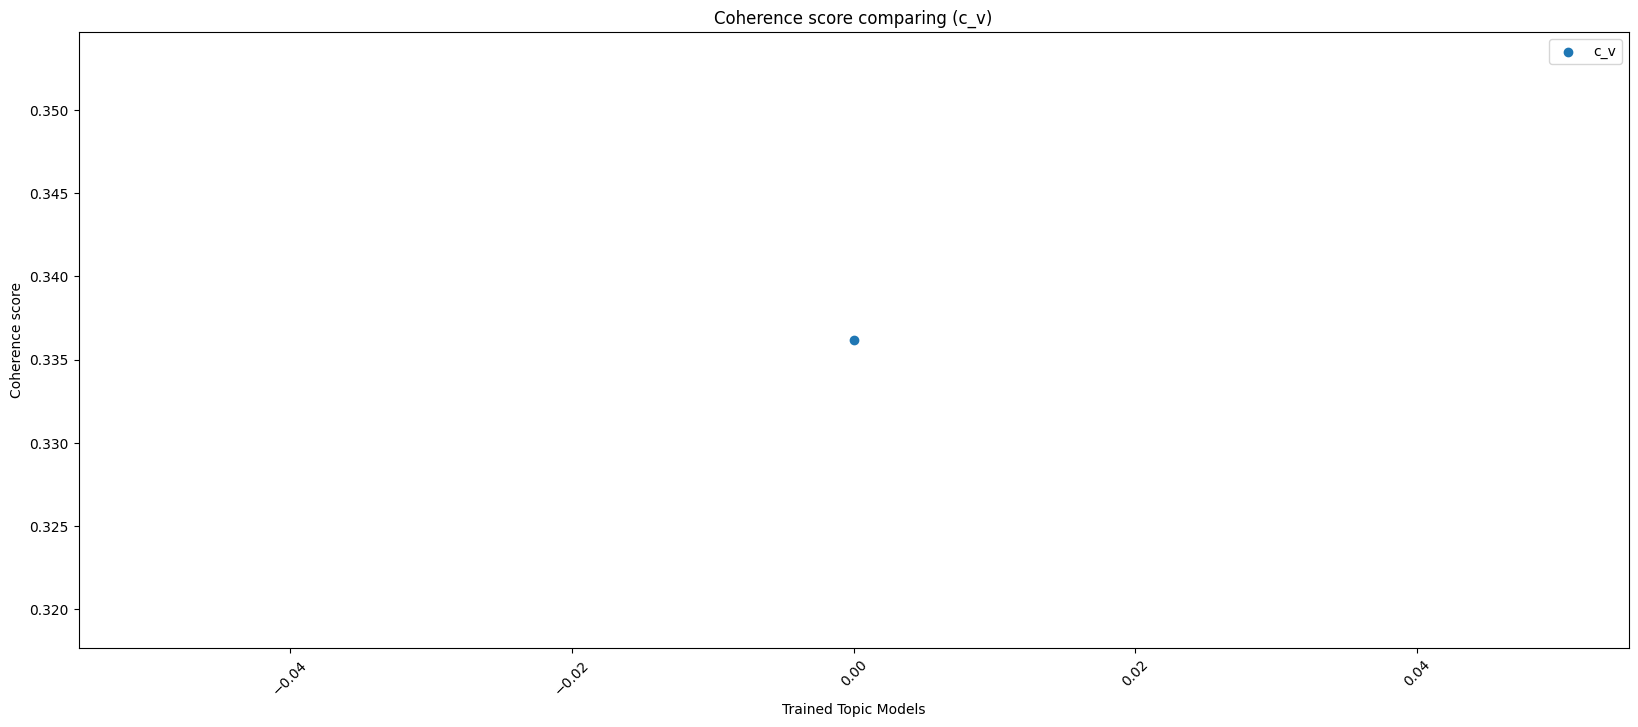

In [125]:
# Customizing and saving the plot
list = []
i = 0
for i in range(len(model_names)):
    list.append(i)
    i += 1

plt.figure(figsize=(20,8))
plt.scatter(list, coherence_values_cv, label ='c_v')
# plt.plot(list, coherence_values_cv, label="c_v")
plt.title("Coherence score comparing (c_v)")
plt.xlabel("Trained Topic Models")
plt.ylabel("Coherence score")
plt.legend()
plt.xticks(rotation=45)

plt.savefig('Figures/Coherence_NumTopics_HyperpOptim.png')
plt.show()


Finding the index with the highest coherence and saving that model for further use

In [126]:

''' What about the highest perplexity? Maybe find the model which has good values for both'''
highest_coherence = []
print(coherence_values_cv)
for value in coherence_values_cv:
    if value > 0.3:
        highest_coherence.append(coherence_values_cv.index(value))

for element in highest_coherence:
    print(model_names[element])

        

[0.33617497534049406]
('10', '300', 'symmetric', 'symmetric')


In [127]:
index_best_model = coherence_values_cv.index(max(coherence_values_cv))

# Select the model and print the topics
optimal_model = model_list_cv[0]
# optimal_model = model_list_cv[index_best_model]
print(coherence_values_cv[index_best_model])

print('Number of topics in the best model: ', model_list_cv[index_best_model].num_topics)
final_num_topics = model_list_cv[index_best_model].num_topics
# optimal_model.save("Models/optimal_model_n17.model", "w")

0.33617497534049406
Number of topics in the best model:  10


## Research Question 1: Topic Modeling

Visualisation of final topic modeling with optimal parameters

In [81]:
# model = gensim.models.ldamodel.LdaModel.load("models/optimal_model_n17.model")

In [128]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.show(vis, local=False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [24/May/2023 15:30:30] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/May/2023 15:30:32] code 404, message Not Found
127.0.0.1 - - [24/May/2023 15:30:32] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


### Further analyses with the optimal topic model from above

For all: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

Getting the most frequent words per topic

In [129]:
optimal_model.show_topics()

[(0,
  '0.015*"text" + 0.004*"abbildung" + 0.004*"daten" + 0.003*"etwa" + 0.003*"digital" + 0.003*"tools" + 0.002*"analyse" + 0.002*"annotation" + 0.002*"edition" + 0.002*"semantisch"'),
 (1,
  '0.014*"digital" + 0.007*"annotation" + 0.005*"text" + 0.005*"methode" + 0.003*"projekt" + 0.003*"technisch" + 0.003*"universität" + 0.002*"dokument" + 0.002*"information" + 0.002*"tools"'),
 (2,
  '0.006*"text" + 0.006*"daten" + 0.004*"deutsch" + 0.004*"analyse" + 0.003*"projekt" + 0.003*"annotation" + 0.003*"methode" + 0.002*"historisch" + 0.002*"abbildung" + 0.002*"visuell"'),
 (3,
  '0.004*"text" + 0.004*"annotation" + 0.003*"historisch" + 0.003*"daten" + 0.003*"use" + 0.003*"abbildung" + 0.003*"analyse" + 0.002*"clarin" + 0.002*"visuell" + 0.002*"beitrag"'),
 (4,
  '0.008*"text" + 0.006*"digital" + 0.005*"annotation" + 0.003*"figur" + 0.003*"modell" + 0.003*"analyse" + 0.002*"information" + 0.002*"historisch" + 0.002*"methode" + 0.002*"abbildung"'),
 (5,
  '0.008*"daten" + 0.005*"annotation

Showing the probabilities of a certain word to belong to the topics

In [130]:
optimal_model.get_term_topics('lexikalisch')

[(0, 0.00019025842),
 (1, 9.393816e-05),
 (2, 0.00014449286),
 (3, 5.0603157e-05),
 (4, 0.00027960527),
 (5, 0.00036026264),
 (6, 0.00032282362),
 (7, 4.8850407e-06),
 (8, 0.00027263348),
 (9, 0.0003293691)]

## Research Question 2: Hierarchical Clustering and Topic Similarity
Hellinger-Distance:
- values between 0 and 1, with 0 = completely similar, 1 = completely different
- compares the probability distribution of topics for two documents
- symmetrical measure, i.e. hellinger(a,b) = hellinger(b,a)
- [Documentation in Gensim](https://radimrehurek.com/gensim/matutils.html#gensim.matutils.hellinger)

Based on document-level similarity, where "topics may appear in some of the same documents" (7884) (Hao et al., 2018) 

--> goal: "describe the interaction structure of research topics" because "[i]f two topics frequently appear in the same publications, there is a big potential to foster a novel interdisciplinary research field" (7889) (Hao et al., 2018)


In [131]:
topics_per_text = []
bow_mann_kendall = []
i = 0

## als Input: Liste von Listen der einzelnen Texte in lemmatisierter/bigramm-Form!

for text in data_bigrams_trigrams:
    #bow-representation of the single text
    bow = optimal_model.id2word.doc2bow(text)
    doc_topics, word_topics, phi_values = optimal_model.get_document_topics(bow, per_word_topics=True)
    
    # #shows the distribution of topics in the single documents
    # print(i, doc_topics)
    
    #saving the topic distribution of each text in a list
    topics_per_text.append(doc_topics)
    i += 1
    
# calculating the distance of each document's topic distribution to any other document's topic distribution with Hellinger Distance 
hellinger_distances = []
for doc in topics_per_text:
    doc_distances = []
    # comparing the distance between the topic distribution of one text to the distribution of all other texts
    for comparison in topics_per_text:
        doc_distances.append(hellinger(doc, comparison))
    # returns list of lists, in which the distance of each document to each other document is saved    
    hellinger_distances.append(doc_distances)   


Visualization of Hellinger-Distance in a dendrogram

C:\Windows\Temp\ipykernel_4964\2801865694.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(hellinger_distances, method='ward'), leaf_rotation=90)


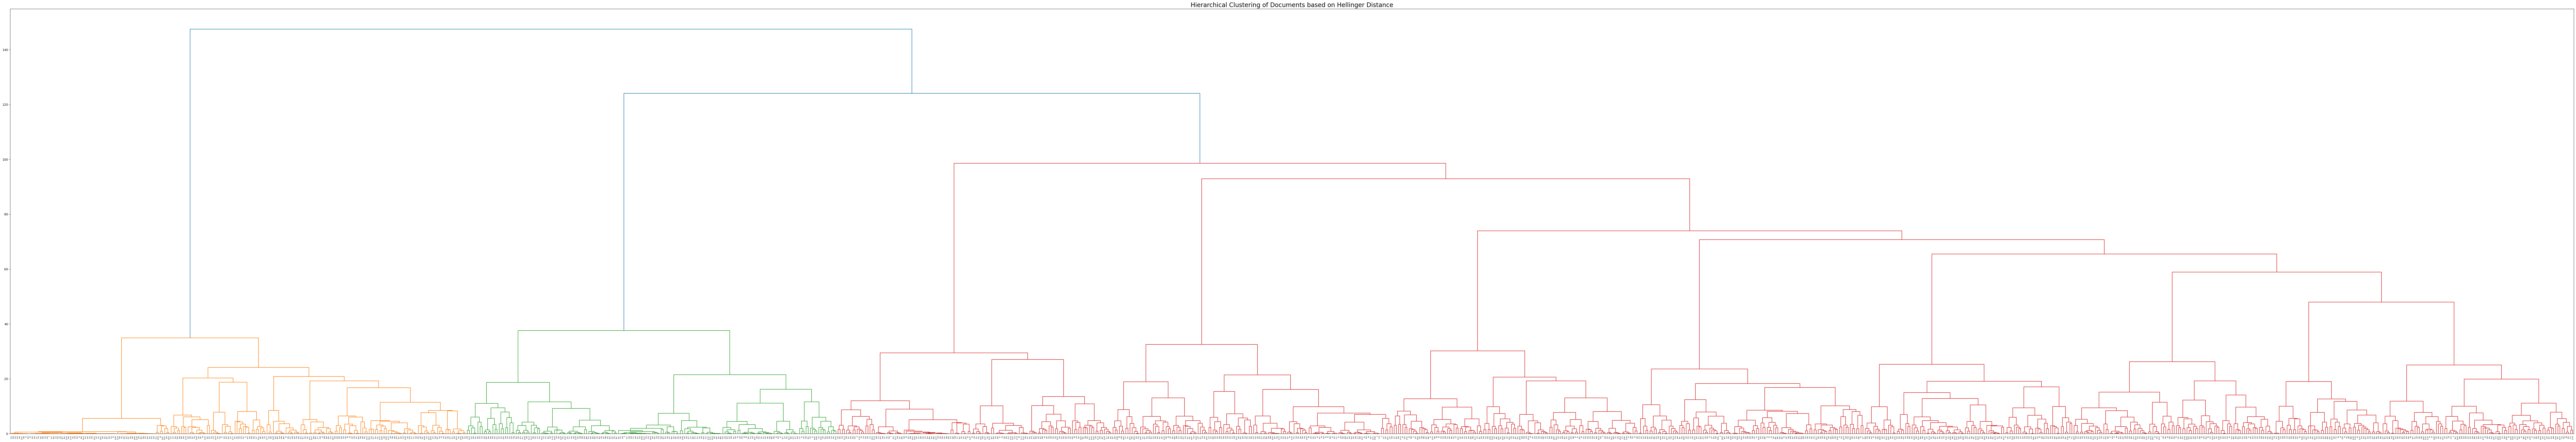

In [155]:
''' From the indexes used in the dendrogramm, how do I get the actual names of the texts or their years? '''

plt.figure(figsize=(150, 25))  
plt.title("Hierarchical Clustering of Documents based on Hellinger Distance", fontsize = 20) 
dend = shc.dendrogram(shc.linkage(hellinger_distances, method='ward'), leaf_rotation=90)

## Research Question 3: Mann-Kendall-Test

Mann-Kendall-Test:

- MK-Test analyzes whether there is a trend in a topic's appearance over time: increasing, decreasing, no trend (Chen et al., 2020; Mann, 1945)
- in the following, since there are many documents analyzed with topic distributions for each year, the mean value for each topic over all documents was taken to conduct the MK-Test
- [Information on Mann-Kendall-Test](https://www.geeksforgeeks.org/how-to-perform-a-mann-kendall-trend-test-in-python/)

In [156]:
def calculate_topic_average(indexes, topics_per_text):
    # calculating the average probability of a certain topic per year
    averages_per_topic_per_year = []
    i = 0 
    j = 1
    while i < int(len(indexes)-1):
        all_probs = []
        for text in topics_per_text[indexes[i]:indexes[j]]:
            probs = []
            for tuple in text:
                topic, probability = tuple
                # extracting only the probability values from the tuple
                probs.append(probability)
            all_probs.append(probs)
        # dividing the sum of all first, second, third... values by the number of values to get the average of all n topics for one year
        averages_per_topic = (np.sum(all_probs, axis=0)/len(all_probs))
        averages_per_topic_per_year.append(averages_per_topic)
        i +=1
        j += 1
    return averages_per_topic_per_year

In [229]:
# using the list of names of documents for each year to count how many documents belong to one year
indexes = [0]
for sublist in docnames:
    indexes.append(len(sublist) + indexes[-1])

topic_averages = calculate_topic_average(indexes, topics_per_text)

# creating a dataframe which shows the average probability of a topic in each year
df = pd.DataFrame(topic_averages, index=filenames).T
print(df)


   DHd_2014.zip  DHd_2015.zip  DHd_2016.zip  DHd_2017.zip  DHd_2018.zip   
0      0.076075      0.084743      0.065551      0.085898      0.071754  \
1      0.133152      0.154729      0.132367      0.160513      0.133562   
2      0.122159      0.121306      0.115162      0.059113      0.103149   
3      0.071972      0.035081      0.044801      0.030105      0.049052   
4      0.041786      0.033521      0.020088      0.052179      0.044465   
5      0.111895      0.161814      0.220163      0.167589      0.164435   
6      0.208630      0.179081      0.204124      0.225091      0.237317   
7      0.125103      0.066924      0.080386      0.120097      0.069346   
8      0.067732      0.059499      0.050089      0.058108      0.055269   
9      0.041495      0.103302      0.067269      0.041308      0.071652   

   DHd_2019.zip  DHd_2020.zip  DHd_2022.zip  DHd_2023.zip  
0      0.077367      0.079602      0.052877      0.056550  
1      0.125768      0.111077      0.100821      0.143

Visualisation of the development of topic probability averages per year

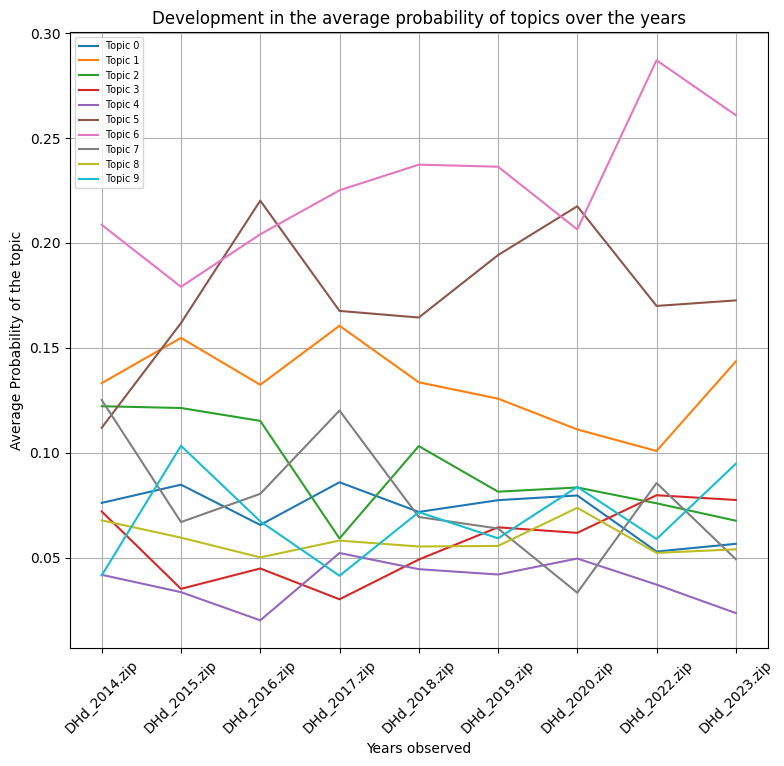

In [177]:
# creating a plot for visualisation
plt.figure(figsize=(9,8))
plt.title("Development in the average probability of topics over the years")
plt.xlabel("Years observed")
plt.ylabel("Average Probability of the topic")

plt.xticks(rotation=45)
for i in range(0, final_num_topics):  
    # creating a line plot showing the development trends of each topic per year
    plt.plot(filenames, df.values[i], label=str('Topic ' + str(i)))
    plt.legend(loc='best', fontsize='x-small')
plt.grid(True)
plt.show()   


Mann-Kendall-Test for each topic:

- results are statistically significant if p <= 0.05
- results are highly statistically significant if p <= 0.01

In [180]:
for i in range(0, final_num_topics, 1):
    # MK-Test for each topic and its average value
    print(i, mk.original_test(df.values[i]))


0 Mann_Kendall_Test(trend='no trend', h=False, p=0.34808262363292397, z=-0.9383148632568366, Tau=-0.2777777777777778, s=-10.0, var_s=92.0, slope=-0.0022695225973924, intercept=0.08515309294064839)
1 Mann_Kendall_Test(trend='no trend', h=False, p=0.2514521865080219, z=-1.1468292773139113, Tau=-0.3333333333333333, s=-12.0, var_s=92.0, slope=-0.004148871770926884, intercept=0.1497473610298974)
2 Mann_Kendall_Test(trend='decreasing', h=True, p=0.01648865672767008, z=-2.39791576165636, Tau=-0.6666666666666666, s=-24.0, var_s=92.0, slope=-0.007552470390995344, intercept=0.11361457904179892)
3 Mann_Kendall_Test(trend='no trend', h=False, p=0.11785089502136503, z=1.563858105428061, Tau=0.4444444444444444, s=16.0, var_s=92.0, slope=0.005747816170610133, intercept=0.03879111402091526)
4 Mann_Kendall_Test(trend='no trend', h=False, p=0.9169652366288645, z=-0.10425720702853739, Tau=-0.05555555555555555, s=-2.0, var_s=92.0, slope=-0.0007724896782920474, intercept=0.04487586198818116)
5 Mann_Kendall

## Research Question 4: Development and Use of Research Methods

Function find_popular_methods extracts all methods appearing within the five most-used methods from every corpus/DHd year and saves them in a list, which is then used by the following function

In [181]:
''' EVTL prozentuale Verteilung berechnen, um den verschieden großen Korpora gerecht zu werden? '''
def find_popular_methods(methods):
    # takes sorted list as input in which the methods used and their count (how often were they used/stated as keyword in each year?) is saved
    popular_methods = []
    for year in methods:
        # extracts the first five methods (the ones with the highest count) and appends them to another list, in which only the method itself is saved
        best_five = year[:5]
        for item in best_five: 
            res_method, count = item
            if res_method not in popular_methods:
                popular_methods.append(res_method)
    return popular_methods

Function count_popular_methods uses the list returned from find_popular_methods and creates a dictionary with each years' counts of those popular methods, relative to the number of texts in the respective year's corpus

In [227]:
def count_popular_methods(popular_methods, number_xml_docs):
    # takes list of the most popular methods as input
    # creates dictionary which saves the method and how often it is used over time in each of the conference corpora
    year_count_methods = {}
    for meth in popular_methods:
        absolute_count = []
        for year in methods:
            for item in year:
                res_method, count = item
                # for every method in the popular methods (appearing in the top5 of each year), analyze how often it appears each year
                if res_method == meth:
                    absolute_count.append(count)
        # in order to take into account varying corpus sizes over the years, take relative number instead of absolute number
        # relative number = number of texts in the specific year's corpus
        relative_count=[]
        for i in range(len(absolute_count)):
            relative_count.append(round(absolute_count[i]/number_xml_docs[i], 3)) 
        year_count_methods[meth] = relative_count  
        
    # return dictionary with methods as keys and list of relative value how often the method was mentioned in the corpus of the specific year
    return year_count_methods 

In [228]:
# how many texts are in each year's corpus taken into account?
number_xml_docs = []      
for sublist in doc_names_xml:
  number_xml_docs.append(len(sublist))  

popular_methods = find_popular_methods(methods)
year_count_methods = count_popular_methods(popular_methods, number_xml_docs)

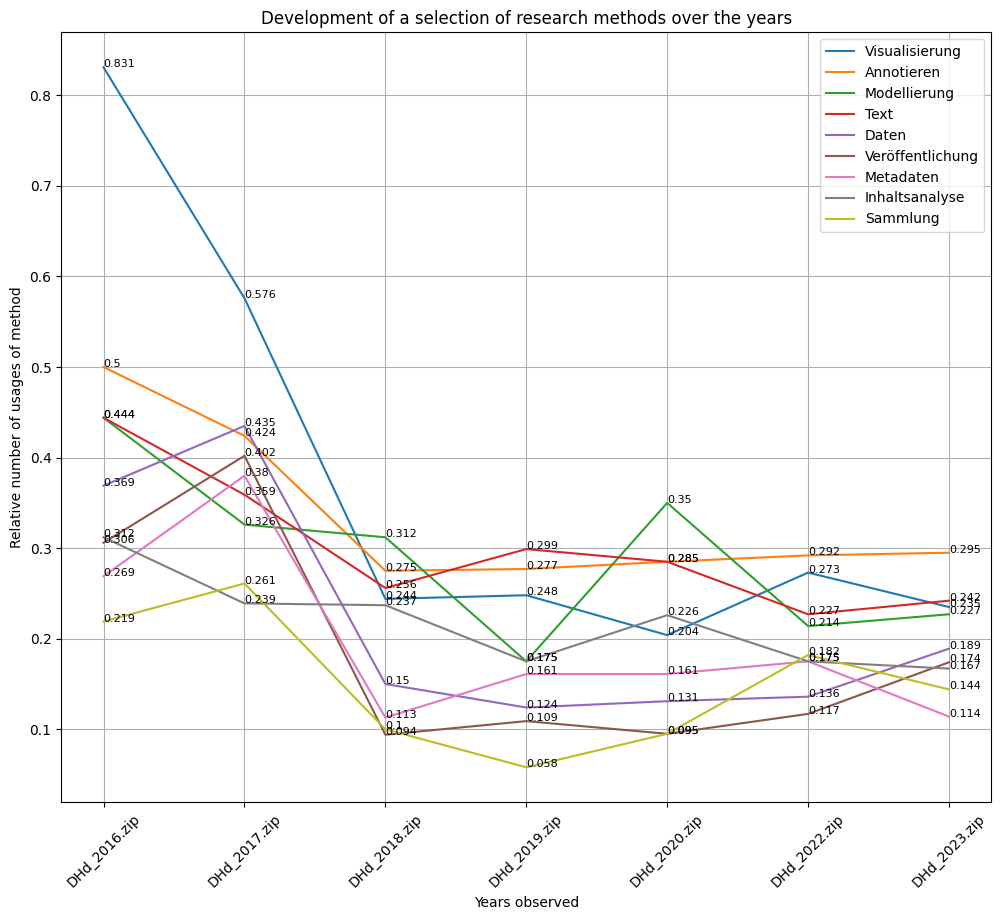

' If grid is used, maybe delete the numbers for each data point? '

In [225]:
# creating a plot for visualisation
fig, ax = plt.subplots(figsize=(12,10))
# plt.figure(figsize=(10,8))
plt.title("Development of a selection of research methods over the years")
plt.xlabel("Years observed")
plt.ylabel("Relative number of usages of method")

plt.xticks(rotation=45)
for key in year_count_methods:
      plt.plot(filenames_xml, year_count_methods[key], label=key)
      # following 2 lines are for creating the small numbers at each data point
      for index in range(len(filenames_xml)):
        ax.text(filenames_xml[index], year_count_methods[key][index], year_count_methods[key][index], size=8)
      plt.legend(loc='upper right')
plt.grid(True)
plt.show()  
    
''' If grid is used, maybe delete the numbers for each data point? '''

## Research Question 5: Analysis of Authors and Teams of Authors

Authors extracted already, how to compare? 

## Research Question 6: Clustering of (Teams of) Authors and certain Research Topics